In [1]:
# Gerekli kütüphaneleri içe aktaralım
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings

# Uyarıları kapatalım
warnings.filterwarnings('ignore')

In [2]:
# Veri setini yükleyelim
data = pd.read_csv('/kaggle/input/sales-and-customer-insights/sales_and_customer_insights.csv')

# Verinin rastgele 20 satırını görelim
print(data.sample(20))

# Verinin temel bilgilerini görelim (kolon isimleri, veri türleri, eksik değerler)
data.info()


      Customer_ID   Product_ID Transaction_ID  Purchase_Frequency  \
3685  CUST_XY94A4  PROD_PITG6L   TRANS_2KWUHN                  17   
6846  CUST_BUQKEA  PROD_UZG9TZ   TRANS_HF13GM                  19   
4519  CUST_9LJWU0  PROD_UJY1NS   TRANS_O5MGRW                   9   
1558  CUST_OQ6CBD  PROD_1WIYF3   TRANS_JJ2MCY                  18   
460   CUST_8S3F9Q  PROD_K58YB2   TRANS_YHPYFY                   2   
3490  CUST_7C0W10  PROD_JQDAK5   TRANS_WCJ1D9                   4   
5507  CUST_E0BTC9  PROD_6BARBM   TRANS_0KZC9U                  14   
1744  CUST_R18FXT  PROD_EMNWWM   TRANS_HCFPPI                   2   
1205  CUST_VNAFY0  PROD_OJRL0E   TRANS_L5HCZA                   9   
2489  CUST_SYUHSU  PROD_M80CA3   TRANS_OV59KR                  15   
3512  CUST_KFBGEG  PROD_KW0AGF   TRANS_E5SIZJ                   9   
9787  CUST_19QEY0  PROD_TSZTIJ   TRANS_NSUR8Z                  16   
5412  CUST_B9NCOY  PROD_LFJQIH   TRANS_8I3PKL                  17   
6827  CUST_LHA3XG  PROD_TN8X79   T

**Tarih Kolonlarının Dönüştürülmesi**

In [3]:
# Tarih kolonlarını datetime formatına çevirelim
data['Launch_Date'] = pd.to_datetime(data['Launch_Date'])
data['Peak_Sales_Date'] = pd.to_datetime(data['Peak_Sales_Date'])

**Bölgelere Göre Müşteri Dağılımının Görselleştirilmesi**

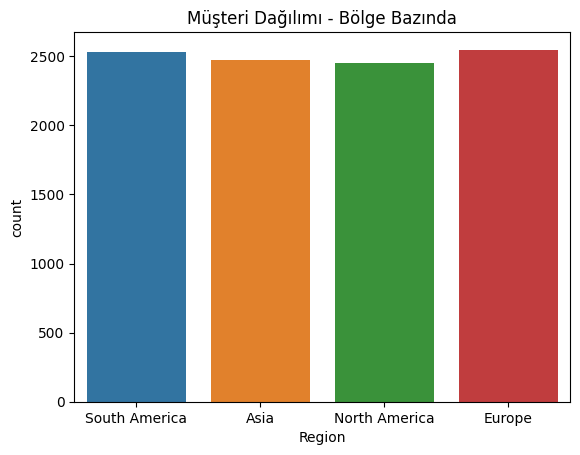

In [4]:
# Bölgeler arasındaki müşteri dağılımını görselleştirelim
sns.countplot(data=data, x='Region')
plt.title('Müşteri Dağılımı - Bölge Bazında')
plt.show()


**Özelliklerin Seçilmesi ve Verinin Ölçeklendirilmesi**

In [5]:
# Kümelenme için kullanacağımız özellikleri seçelim
features = ['Purchase_Frequency', 'Average_Order_Value', 'Churn_Probability', 'Time_Between_Purchases', 'Lifetime_Value']

# Veriyi ölçeklendirelim
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[features])


**Elbow Yöntemi ile Optimum Küme Sayısının Belirlenmesi**

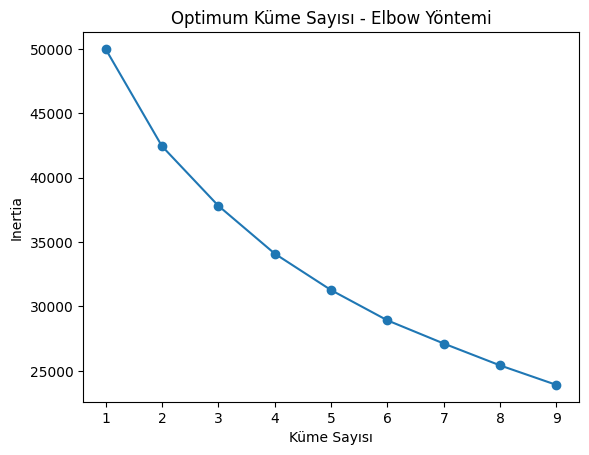

In [6]:
# Elbow Yöntemi ile optimum küme sayısını bulalım
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Elbow grafiğini çizelim
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Optimum Küme Sayısı - Elbow Yöntemi')
plt.xlabel('Küme Sayısı')
plt.ylabel('Inertia')
plt.show()


**Optimal Küme Sayısı ile KMeans Kümeleme Uygulaması**

In [7]:
# Elbow Yöntemi'nden optimal küme sayısını seçelim (Örneğin, 4)
optimal_clusters = 4

# KMeans kümeleme algoritmasını uygulayalım
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_data)


**PCA ile Boyut İndirgeme ve Küme Görselleştirmesi**

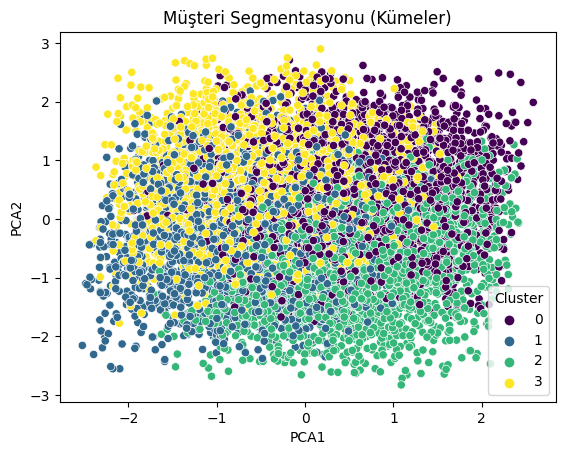

In [8]:
# PCA ile veriyi 2D'ye indirgemek
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# PCA bileşenlerini veri çerçevesine ekleyelim
data['PCA1'] = reduced_data[:, 0]
data['PCA2'] = reduced_data[:, 1]

# Kümeleme sonuçlarını PCA bileşenleriyle görselleştirelim
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=data, palette='viridis')
plt.title('Müşteri Segmentasyonu (Kümeler)')
plt.show()


**Bölgelere Göre Küme Dağılımının Görselleştirilmesi**

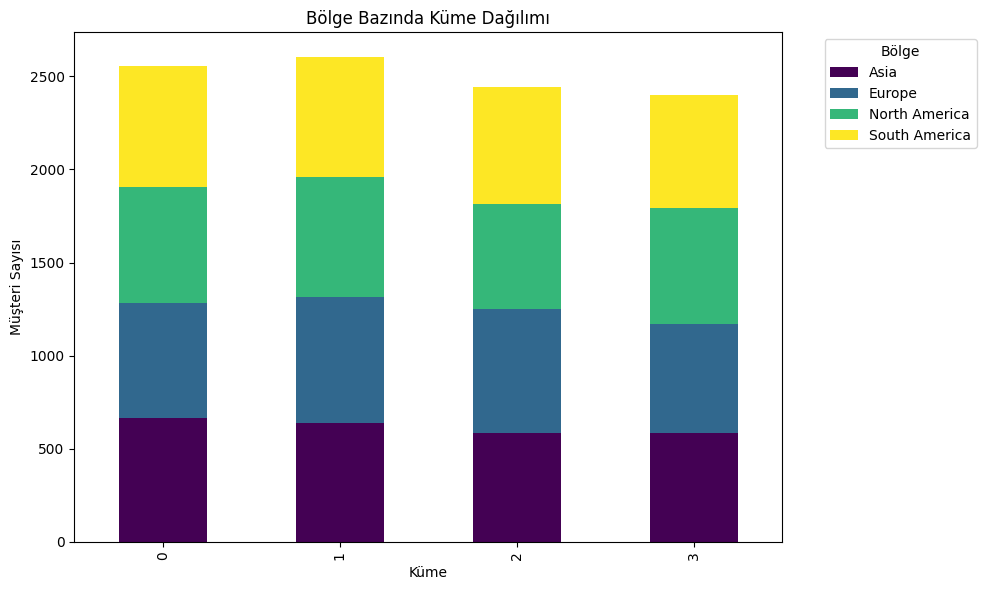

In [9]:
# Bölgelere göre küme dağılımını inceleyelim
region_distribution = data.groupby(['Cluster', 'Region']).size().unstack()

# Dağılımı bar grafiği ile gösterelim
region_distribution.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title("Bölge Bazında Küme Dağılımı")
plt.xlabel("Küme")
plt.ylabel("Müşteri Sayısı")
plt.legend(title="Bölge", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Küme Özelliklerini İnceleyerek Yorumlama**

In [10]:
# Küme başına ortalama değerleri inceleyelim
cluster_summary = data.groupby('Cluster')[features].mean()
print(cluster_summary)


         Purchase_Frequency  Average_Order_Value  Churn_Probability  \
Cluster                                                               
0                 14.099452           157.570243           0.531707   
1                  5.391404           128.160871           0.480760   
2                 14.390004            63.906653           0.525825   
3                  5.990413            86.553752           0.467336   

         Time_Between_Purchases  Lifetime_Value  
Cluster                                          
0                     45.137431     6167.602063  
1                     45.933231     2563.092782  
2                     46.017206     3841.967898  
3                     50.663610     7715.542547  


**Silhouette Skoru ile Model Performansını Değerlendirme**

In [11]:
from sklearn.metrics import silhouette_score

# Silhouette skorunu hesaplayalım
silhouette_avg = silhouette_score(scaled_data, data['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.14697089301639524
